In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns


from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer, accuracy_score

In [3]:
long = pd.read_csv('all_stocks_5yr.csv')
long.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [10]:
# using all unique timestamp and closing price as columns for Xs and Y
# company names as row names 

timecol = long['Date'].unique()

dt = long[['Date', 'Close', 'Name']]

# len(dt[dt['Date'] == '2012-08-13'])

In [6]:
# data restructure 

refold = pd.pivot_table(dt, index = 'Name', columns = 'Date', values = 'Close').reset_index()
refold.head()

Date,Name,2012-08-13,2012-08-14,2012-08-15,2012-08-16,2012-08-17,2012-08-20,2012-08-21,2012-08-22,2012-08-23,...,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11
0,A,40.38,40.49,40.48,37.15,37.22,36.68,37.13,37.46,37.47,...,59.79,59.94,60.20,60.37,60.13,60.87,60.14,59.68,58.57,59.33
1,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.44,51.06,50.45,50.55,50.80,50.58,50.00,49.40,48.55,48.35
2,AAP,69.11,70.67,71.30,72.46,72.87,71.58,72.00,72.20,71.96,...,112.01,114.05,114.48,110.53,111.01,109.49,109.39,109.18,106.13,107.34
3,AAPL,90.00,90.24,90.12,90.91,92.59,95.02,93.72,95.55,94.66,...,148.73,150.05,157.14,155.57,156.39,158.81,160.08,161.06,155.32,157.48
4,ABBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.91,70.38,70.71,70.99,70.99,71.22,71.47,72.02,70.44,70.63


In [12]:
# replace NaN with row average

ref = refold.T.fillna(refold.mean(axis = 1)).T
ref.head()

Date,Name,2012-08-13,2012-08-14,2012-08-15,2012-08-16,2012-08-17,2012-08-20,2012-08-21,2012-08-22,2012-08-23,...,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11
0,A,40.38,40.49,40.48,37.15,37.22,36.68,37.13,37.46,37.47,...,59.79,59.94,60.2,60.37,60.13,60.87,60.14,59.68,58.57,59.33
1,AAL,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,...,50.44,51.06,50.45,50.55,50.8,50.58,50,49.4,48.55,48.35
2,AAP,69.11,70.67,71.3,72.46,72.87,71.58,72,72.2,71.96,...,112.01,114.05,114.48,110.53,111.01,109.49,109.39,109.18,106.13,107.34
3,AAPL,90,90.24,90.12,90.91,92.59,95.02,93.72,95.55,94.66,...,148.73,150.05,157.14,155.57,156.39,158.81,160.08,161.06,155.32,157.48
4,ABBV,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,...,69.91,70.38,70.71,70.99,70.99,71.22,71.47,72.02,70.44,70.63


In [28]:
# on 2017-08-11, the last recorded date for closing stock price, every company has an entry
# try to predict the trend of closing stock price on 2017-08-11, comparing with the price on 2017-08-10 

sum(ref[ref.columns[-1]].isnull())

# date and price before 8-11 as features and the lables as y

x = ref[ref.columns[1: -1]]


In [53]:
# label stock trend first 

ref['Label'] = np.nan
ref.head()

Date,Name,2012-08-13,2012-08-14,2012-08-15,2012-08-16,2012-08-17,2012-08-20,2012-08-21,2012-08-22,2012-08-23,...,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,Label
0,A,40.38,40.49,40.48,37.15,37.22,36.68,37.13,37.46,37.47,...,59.94,60.2,60.37,60.13,60.87,60.14,59.68,58.57,59.33,NaN
1,AAL,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,...,51.06,50.45,50.55,50.8,50.58,50,49.4,48.55,48.35,NaN
2,AAP,69.11,70.67,71.3,72.46,72.87,71.58,72,72.2,71.96,...,114.05,114.48,110.53,111.01,109.49,109.39,109.18,106.13,107.34,NaN
3,AAPL,90,90.24,90.12,90.91,92.59,95.02,93.72,95.55,94.66,...,150.05,157.14,155.57,156.39,158.81,160.08,161.06,155.32,157.48,NaN
4,ABBV,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,...,70.38,70.71,70.99,70.99,71.22,71.47,72.02,70.44,70.63,NaN


In [60]:
# 8-11
aug11 = ref.iloc[:, -2]

# 8-10
aug12 = ref.iloc[:, -3]

# labels can be changed according to the desired increase in stock price used in stock selection 

# now label 1 as long as stock price increases
# and 0 for decreasing stock price

desired_percentage = 0 

for i in range(len(aug12)):
    if (aug12[i] - aug11[i])/ aug11[i] > desired_percentage:
        ref['Label'].replace([i], 1)
    else:
        ref['Label'].replace([i], 0)
    

In [66]:
# check if the classes are balanced 

y = ref.iloc[:, -1]

print(len(y[y == 1]))
print(len(y[y == 0]))

# seems ok, PCA first, then KNN

256
247


# PCA

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state= 0)

x_mean = np.mean(x, axis = 0)
x_train_norm = x_train - x_mean
x_test_norm = x_test - x_mean


In [76]:
# PCA summary function - where the input variable pca is a PCA object

def pca_summary(pca, standardised_data, out = True):
    names = ["PC" + str(i) for i in range(1, len(pca.explained_variance_ratio_) +  1)]
    a = list(np.std(pca.transform(standardised_data), axis = 0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_) + 1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index = names, columns = columns)
    if out:
        print("Importance of components:")
#         display(summary)
    return summary

In [78]:
pca = PCA().fit(x_train_norm)

pca_summary(pca, x_train_norm)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,2.991583e+03,9.506357e-01,0.950636
PC2,4.865658e+02,2.514753e-02,0.975783
PC3,3.220231e+02,1.101504e-02,0.986798
PC4,2.187830e+02,5.084393e-03,0.991883
PC5,1.303453e+02,1.804689e-03,0.993687
PC6,1.136482e+02,1.371946e-03,0.995059
PC7,9.528587e+01,9.644263e-04,0.996024
PC8,7.098698e+01,5.352658e-04,0.996559
PC9,6.789732e+01,4.896856e-04,0.997049


In [82]:
# fit and transform x using PCA(n = 3)
pca = PCA(n_components = 3).fit(x_train_norm)
pcax_train = pca.transform(x_train_norm)

In [183]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

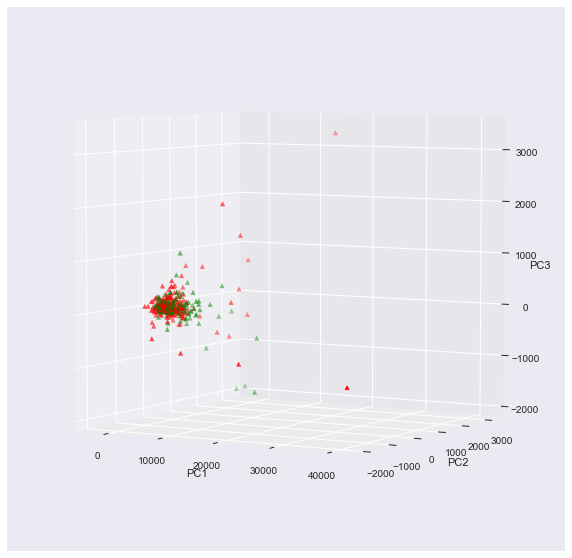

In [191]:
# visualize classes on the new PCA dimension 
# y_train contains true labels 

fig = pylab.figure( figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
color= ['red' if yi == 0 else 'green' for yi in y_train]

sc = ax.scatter(pcax_train[:, 0], pcax_train[:, 1], pcax_train[:, 2], c = color, marker = '^')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Set rotation angle to 30 degrees
# ax.view_init(azim = 150)
# Set the elevation angle 
ax.view_init(elev = 5)

In [179]:
# set elev first and rotate the pic for the best azim

# for ii in xrange(0,360,1):
#     ax.view_init(elev=10., azim=ii)
#     savefig("movie%d.png" % ii)

# KNN

In [91]:
# tuning for the best number of k on training data x
# accuracy 

accuracy_rate = make_scorer(accuracy_score)
neighbours = np.arange(1, 10, 2)
accuracy = []

for k in neighbours:
    pca_knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(pca_knn, pcax_train, y_train, cv = 10, scoring = accuracy_rate)
    accuracy.append(scores.mean())
    
neighbours[accuracy.index(min(accuracy))]

5

In [92]:
accuracy

[0.54744684177611003,
 0.51987335834896808,
 0.51262351469668543,
 0.52537992495309571,
 0.52281269543464659]

In [95]:
# tuning for the best number of k on the complete dataset
# accuracy 

fullx = pca.transform(x - x_mean)

accuracy_rate = make_scorer(accuracy_score)
neighbours = np.arange(1, 10, 2)
accuracy = []

for k in neighbours:
    pca_knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(pca_knn, fullx, y, cv = 10, scoring = accuracy_rate)
    accuracy.append(scores.mean())
    
neighbours[accuracy.index(min(accuracy))]

7

In [94]:
accuracy

[0.53575350140056033,
 0.53387274909963978,
 0.55164225690276114,
 0.533234093637455,
 0.54907723089235694]

# Evaluation 

In [102]:
pca_knn = KNeighborsClassifier(n_neighbors = 5)
pca_knn.fit(pcax_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [119]:
# transform the testing x to the New PC dimension 

pcax_test = pca.transform(x_test_norm)
pred = pca_knn.predict(pcax_test)

print (sum(pred == y_test))
print (sum(pred == y_test)/ len(y_test))

59
0.584158415842


In [118]:
# eval on the entire data with KNN(k = 5) and PCA(n = 3)

pcax_full = pca.transform(x - x_mean)
pred5f = pca_knn.predict(pcax_full)

print (sum(pred5f == y))
print (sum(pred5f == y)/ len(y))

320
0.636182902584


# Logistic regression


In [192]:
from sklearn.linear_model import LogisticRegression

In [196]:
clf = LogisticRegression()
clf.fit(pcax_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [197]:
clf.score(pcax_test, y_test)

0.60396039603960394

In [202]:
clf.coef_

array([[-0.00010697,  0.00059444, -0.00096652]])

In [205]:
sum(clf.predict(pcax_test) == y_test)/ len(y_test)

0.60396039603960394

# SVM

In [218]:
from sklearn.svm import SVC

In [224]:
# rbf is the default kernel
clf_svm = SVC()
clf_svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [221]:
clf_svm.predict(x_test)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [226]:
# if train SVM on the PCAed data 

# rbf is the default kernel
clf_pcasvm = SVC()
clf_pcasvm.fit(pcax_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [227]:
clf_pcasvm.predict(pcax_test)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])